# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [11]:
from sklearn.model_selection import train_test_split
#making the features 
def make_features(data, max_lag, rolling_mean_size):
    data['Hour']= data.index.hour
    data['DayOfWeek'] = data.index.dayofweek
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['Rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
# apply
data = make_features(data, max_lag=24, rolling_mean_size=24)

# droping the nan introduced by shifting
data.dropna(inplace= True)

features = data.drop('num_orders', axis=1)
target = data['num_orders']

#split to tarin and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.10, shuffle=False, random_state=12345)

## Training

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA


#1/Linear Regression
lr = LinearRegression()

#2/Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=10, random_state=12345)

#3/Random Forest 
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=12345)

#LightGBM
lgbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=100)

#5 ARIMA
#arima = ARIMA(features_train, order=(1, 0, 1))

models = {
    'Linear Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'LightGBM': lgbm,
    #'ARIMA': arima
    
}

best_rmse = float('inf')
best_model = None
best_model_name = ""

for name, model in models.items():
    
    model.fit(features_train, target_train)

    #Prediction
    preds = model.predict(features_test)
    
    rmse = mean_squared_error(target_test, preds, squared=False)
    print(f"{name} RMSE: {rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_model_name = name

print(f"\n Best model is: {best_model_name} with RMSE = {best_rmse:.2f}")

# Fit ARIMA model to the training target
arima_model = ARIMA(target_train, order=(2, 1, 2)) 
arima_result = arima_model.fit()

# Forecast the same length as test set
forecast = arima_result.forecast(steps=len(target_test))

# Calculate RMSE
arima_rmse = mean_squared_error(target_test, forecast, squared=False)
print(f"ARIMA RMSE: {arima_rmse:.2f}")


Linear Regression RMSE: 45.22
Decision Tree RMSE: 53.34
Random Forest RMSE: 44.36
LightGBM RMSE: 42.63

 Best model is: LightGBM with RMSE = 42.63
ARIMA RMSE: 64.04


## Testing

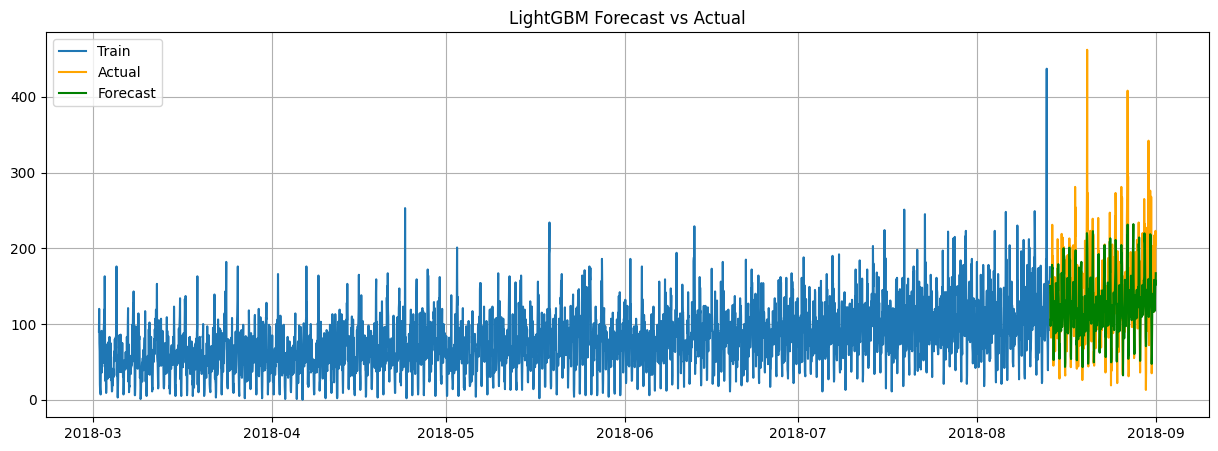

In [13]:
# Plot results
plt.figure(figsize=(15, 5))
plt.plot(target_train.index, target_train, label='Train')
plt.plot(target_test.index, target_test, label='Actual', color='orange')
plt.plot(target_test.index, best_model.predict(features_test), label='Forecast', color='green')
plt.legend()
plt.title(f'{best_model_name} Forecast vs Actual')
plt.grid()
plt.show()

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48